# Toxic language on social media: the dark side of online communication

Social networks, once seen as tools to connect and unite people, have turned into a minefield of aggressive and offensive words. This toxic language, which manifests itself in various forms, such as cyberbullying, hate speech, and online harassment, has very serious consequences for both victims and society as a whole.

# What is toxic language?

- Cyberbullying: targeted attacks to humiliate, intimidate or embarrass someone;
    - [Cyberbullying: conceito, danos, dados no Brasil](https://mundoeducacao.uol.com.br/sociologia/cyberbullying.htm)
- Hate speech: discrimination and prejudice messages that incite violence against minority groups;
    - [Denúncias de crimes envolvendo discurso de ódio nas redes sociais](https://g1.globo.com/jornal-nacional/noticia/2023/05/01/denuncias-de-crimes-envolvendo-discurso-de-odio-nas-redes-sociais-triplicaram-nos-ultimos-6-anos-aponta-levantamento.ghtml)
- Online harassment: persistent stalking and intimidation to pressure and control the victim;
    - [O que é assédio virtual?](https://www.migalhas.com.br/depeso/366628/o-que-e-assedio-virtual)
- Offensive comments: insults, swearing, and other forms of aggressive language directed toward individuals or groups.
     - [Comentários ofensivos nas redes sociais podem caracterizar crime](https://al.rr.leg.br/2020/09/17/comentarios-ofensivos-nas-redes-sociais-podem-caracterizar-crime/)

## What problems can this type of attitude cause?

- Causes suffering: toxic language can generate emotional suffering, anxiety, depression, and even suicidal ideation in victims.
- Creates a hostile environment: it makes the online environment negative and toxic, preventing healthy dialogue and the exchange of constructive ideas.
- Normalizes violence: trivializes aggressive behavior, which can lead to acts of violence in the real world.
- Censorship and self-censorship: silence minority and marginalized voices for fear of attacks and reprisals.

Because of this, we will carry out a detailed analysis of how people behave within social networks and classify whether they are toxic or non-toxic.

This notebook is part of the [Competição de Detecção de Linguagem Tóxica em Mídias Sociais para o Português Brasileiro](https://www.kaggle.com/competitions/ml-olympiad-toxic-language-ptbr-detection/overview) from the platform [Kaggle](https://www.kaggle.com/).

The dataset used was [Toxic Language (PTBR)](https://www.kaggle.com/competitions/ml-olympiad-toxic-language-ptbr-detection/data).

In [1]:
# Configuring the environment:

!pip3 install evaluate
!pip3 uninstall wandb -y

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
Found existing installation: wandb 0.16.2
Uninstalling wandb-0.16.2:
  Successfully uninstalled wandb-0.16.2


In [2]:
# Libraries used:

import os
import torch
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import re
import matplotlib.pyplot as plt
import evaluate
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import DatasetDict, Dataset
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TrainingArguments, 
                          Trainer, 
                          DataCollatorWithPadding, 
                          TextClassificationPipeline, 
                          pipeline, 
                          EvalPrediction)

2024-03-01 19:25:50.106419: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 19:25:50.106550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 19:25:50.247028: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Configuring Pandas:

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x:'%.2f' % x)

In [4]:
# Configuring the GPU for dynamic memory:

memoria_dinamica = os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
print(f"Dynamic memory: {memoria_dinamica}")

Dynamic memory: true


In [5]:
# Checking active GPUs by Torch:

num_gpus = torch.cuda.device_count()-1
gpu_name = torch.cuda.get_device_name(0)
gpu_index = torch.cuda.get_device_properties(0)
print(f"GPU: {num_gpus} \n"
      f"Name: {gpu_name} \n"
      f"Index: {gpu_index}")

# Definir o dispositivo (GPU ou CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

GPU: 0 
Name: Tesla P100-PCIE-16GB 
Index: _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16276MB, multi_processor_count=56)
Device: cuda


In [6]:
# Configuring WANDB:

os.environ["WANDB_SILENT"] = "true"
#os.environ['WANDB_MODE'] = 'dryrun'

# Initial data analysis

In [7]:
# Importing the Dataframe used:

df_toxic = pd.read_csv('/kaggle/input/ml-olympiad-toxic-language-ptbr-detection/train (2).csv')
df_toxic_test = pd.read_csv('/kaggle/input/ml-olympiad-toxic-language-ptbr-detection/test (4).csv')

In [8]:
# Viewing the dataframe:

df_toxic.head(10)

,text,label
0,"rt @user olha quem chegouuuuu, nossos queridin...",0
1,veio umas teorias muito loucas na minha cabeça...,1
2,@user @user 😂😂😂😂mais nao tinha falado ontem qu...,0
3,rt @user quer ser filha da puta logo comigo qu...,1
4,vai besta 😂😂😂😂 casquei com a ultima foto,1
5,"rt @user @user não sei oq é mais chocante, um ...",1
6,@user pois é mano que coisa chata da porra,0
7,rt @user eu odeio sentir ódio de alguém pq eu ...,1
8,se eu ganhar raspo minha cabeça\n https://t.co...,0
9,rt @user @user vlw mano tmj 鉂ゐ煉煆�,0


In [9]:
# Checking the total for each label:

df_toxic['label'].value_counts()

label
0    9425
1    7375
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='label'>

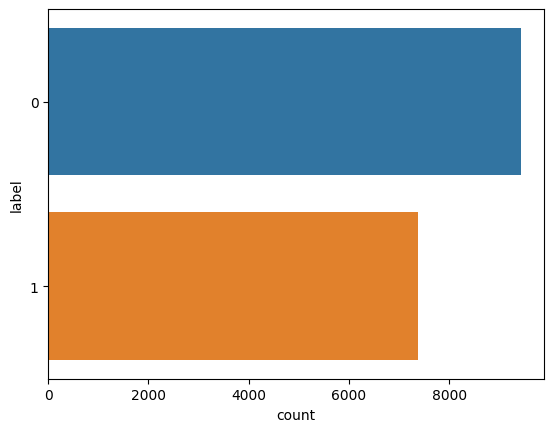

In [10]:
# Graphically analyzing the labels:

sns.countplot(data=df_toxic, y='label')

In [11]:
# Replacing categorical and ordinal variables:

df_toxic['nao_toxico'] = df_toxic['label'].map({0:1, 1:0})
df_toxic['toxico'] = df_toxic['label'].map({0:0, 1:1})

In [12]:
# Viewing the dataframe:

df_toxic.head(10)

,text,label,nao_toxico,toxico
0,"rt @user olha quem chegouuuuu, nossos queridin...",0,1,0
1,veio umas teorias muito loucas na minha cabeça...,1,0,1
2,@user @user 😂😂😂😂mais nao tinha falado ontem qu...,0,1,0
3,rt @user quer ser filha da puta logo comigo qu...,1,0,1
4,vai besta 😂😂😂😂 casquei com a ultima foto,1,0,1
5,"rt @user @user não sei oq é mais chocante, um ...",1,0,1
6,@user pois é mano que coisa chata da porra,0,1,0
7,rt @user eu odeio sentir ódio de alguém pq eu ...,1,0,1
8,se eu ganhar raspo minha cabeça\n https://t.co...,0,1,0
9,rt @user @user vlw mano tmj 鉂ゐ煉煆�,0,1,0


## Text processing

In [13]:
# Text cleaning function:

def limpeza(sentence):
    
    sentence = re.sub(r'(  +.*?)', ' ', sentence) # Replacing multiple spaces
    
    sentence = re.sub('http\S+|www.\S+', '', sentence) # Removal Links
    sentence = re.sub(r'\S*@\S*',"", sentence) # Remove username from email
    
    sentence = re.sub(r'rt ', '', sentence)
       
    sentence = sentence.lower() # Removing all capitalized words
    sentence = re.sub(r'\n', ' ', sentence) # Removing line breaks
    sentence = re.sub(r'\t', ' ', sentence) # Removing tab
    sentence = re.sub(r'[{},._!?;\(\):><@\#-$+=%\"\'&*+^|\[\]]', ' ', sentence) # Removing special characters
    sentence = re.sub(r'((\d+/\d+/\d+)|(\d+/\d+))', 'data', sentence) # Removing dates
    sentence = re.sub(r'([0-9])', ' ', sentence) # Removing numbers
    sentence = re.sub(r'(  +.*?)', ' ', sentence) # Replacing multiple spaces
    sentence = sentence.strip() # Removing leading and trailing spaces
    
    return sentence

In [14]:
# Performing text cleaning:

df_toxic['text_limpo'] = df_toxic['text'].apply(lambda tr: limpeza(tr))
df_toxic_test['text_limpo'] = df_toxic_test['text'].apply(lambda tr: limpeza(tr))

In [15]:
# Viewing the dataframe:

df_toxic.head()

,text,label,nao_toxico,toxico,text_limpo
0,"rt @user olha quem chegouuuuu, nossos queridin...",0,1,0,olha quem chegouuuuu nossos queridinhos vem na...
1,veio umas teorias muito loucas na minha cabeça...,1,0,1,veio umas teorias muito loucas na minha cabeça...
2,@user @user 😂😂😂😂mais nao tinha falado ontem qu...,0,1,0,😂😂😂😂mais nao tinha falado ontem que não ia ser...
3,rt @user quer ser filha da puta logo comigo qu...,1,0,1,quer ser filha da puta logo comigo que sou x p...
4,vai besta 😂😂😂😂 casquei com a ultima foto,1,0,1,vai besta 😂😂😂😂 casquei com a ultima foto


## Separando as bases para treinamento e validação

In [16]:
# Separating the training and validation bases:

train = 0.70
validation = 0.30

val_tre = (1 - train)

df_train, df_val = train_test_split(df_toxic, 
                                    test_size=val_tre,
                                    stratify=df_toxic['label'], 
                                    random_state=42)

In [17]:
# Viewing dataframe numbers:

df_train.shape, df_val.shape

((11759, 5), (5041, 5))

## Text size by classes in the training Dataframe

In [18]:
# Performing the word count:

df_number = df_train.copy()
df_number['tamanho_text'] = df_number['text'].str.split().apply(len)

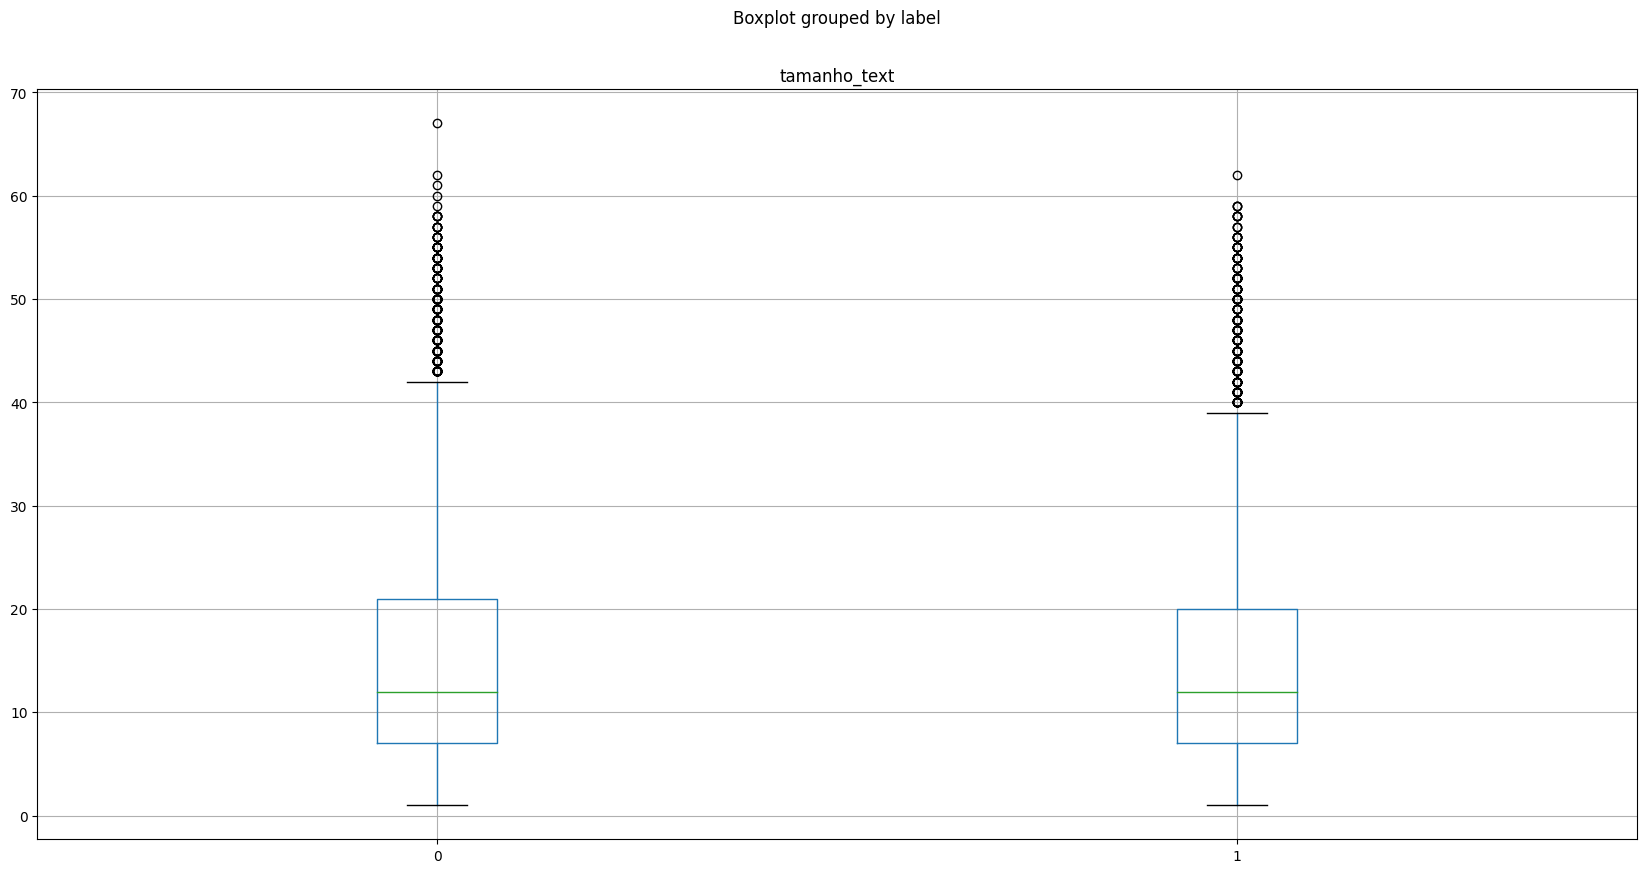

In [19]:
# Visualizing the sizes of the training words graphically:

df_number.boxplot('tamanho_text',
                  by='label',
                  grid=True,
                  showfliers=True,
                  figsize=(20, 10))
plt.xlabel('');

## Preparing data for training

In [20]:
# Loading the Tokenizer:

tokenizer = AutoTokenizer.from_pretrained('citizenlab/distilbert-base-multilingual-cased-toxicity')

tokenizer_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [21]:
# Creating the function to perform tokenization:

def tok(text):
    
    text = str(text)
    text_tk = tokenizer(text, return_tensors="pt", max_length=50, padding='max_length', truncation=True)
    
    return text_tk

In [22]:
# Performing tokenization of training, validation, and test texts:

#train
df_train['inputs'] = df_train['text_limpo'].apply(lambda tk: tok(tk))

#validation
df_val['inputs'] = df_val['text_limpo'].apply(lambda tk: tok(tk))

#test
df_toxic_test['inputs'] = df_toxic_test['text_limpo'].apply(lambda tk: tok(tk))

In [23]:
# Viewing the dataframe:

df_train.head()

,text,label,nao_toxico,toxico,text_limpo,inputs
8361,nunca vou esquecereeer,0,1,0,nunca vou esquecereeer,"[input_ids, attention_mask]"
2666,paraíba do dindo .. 👏👊,0,1,0,paraíba do dindo 👏👊,"[input_ids, attention_mask]"
916,@user ele tem bicha,1,0,1,ele tem bicha,"[input_ids, attention_mask]"
6896,nossa senhora que mulher que mulher meus amigo...,1,0,1,nossa senhora que mulher que mulher meus amigo...,"[input_ids, attention_mask]"
8140,"estes são tipo os filhos gémeos do jmendes, nã...",0,1,0,estes são tipo os filhos gémeos do jmendes não...,"[input_ids, attention_mask]"


In [24]:
# Viewing the dataframe:

df_val.head()

,text,label,nao_toxico,toxico,text_limpo,inputs
9755,@user o país está infestado de boçais e troglo...,1,0,1,o país está infestado de boçais e trogloditas ...,"[input_ids, attention_mask]"
12976,@user Quanto não deve ter sido pago por esse m...,1,0,1,quanto não deve ter sido pago por esse mural 😆...,"[input_ids, attention_mask]"
15456,@user ridículo,1,0,1,ridículo,"[input_ids, attention_mask]"
13401,"sabadoooooou, né non?? salve cambada https://t...",0,1,0,sabadoooooou né non salve cambada,"[input_ids, attention_mask]"
15013,"@user @user @user @user infelizmente, não........",0,1,0,infelizmente não,"[input_ids, attention_mask]"


In [25]:
# Viewing the dataframe:

df_toxic_test.head()

,id,text,text_limpo,inputs
0,0,@user nossa mano te odeio na moral kkkkkkkkkkk...,nossa mano te odeio na moral kkkkkkkkkkkkkkkkkkk,"[input_ids, attention_mask]"
1,1,@user @user a edição ficou muito boa! kkkkkkkk...,a edição ficou muito boa kkkkkkkkkkk mas falto...,"[input_ids, attention_mask]"
2,2,"@user largada vá, visto que a vaca anda à solta 😂",largada vá visto que a vaca anda à solta 😂,"[input_ids, attention_mask]"
3,3,"poxa, eu queria ganhar um boné. alguém me da u...",poxa eu queria ganhar um boné alguém me da um ...,"[input_ids, attention_mask]"
4,4,"@user amiga, tudo bem, não precisa se desculpa...",amiga tudo bem não precisa se desculpar com el...,"[input_ids, attention_mask]"


In [26]:
# Organizing data for training:

#train
df_train['input_ids'] = df_train['inputs'].apply(lambda x: x['input_ids'].tolist())
df_train['attention_mask'] = df_train['inputs'].apply(lambda x: x['attention_mask'].tolist())

#validation
df_val['input_ids'] = df_val['inputs'].apply(lambda x: x['input_ids'].tolist())
df_val['attention_mask'] = df_val['inputs'].apply(lambda x: x['attention_mask'].tolist())

#test
df_toxic_test['input_ids'] = df_toxic_test['inputs'].apply(lambda x: x['input_ids'].tolist())
df_toxic_test['attention_mask'] = df_toxic_test['inputs'].apply(lambda x: x['attention_mask'].tolist())

In [27]:
# Viewing the dataframe:

df_train.head()

,text,label,nao_toxico,toxico,text_limpo,inputs,input_ids,attention_mask
8361,nunca vou esquecereeer,0,1,0,nunca vou esquecereeer,"[input_ids, attention_mask]","[[101, 19096, 12556, 10138, 10196, 11189, 5115...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,..."
2666,paraíba do dindo .. 👏👊,0,1,0,paraíba do dindo 👏👊,"[input_ids, attention_mask]","[[101, 10220, 10545, 10537, 10149, 10595, 1031...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,..."
916,@user ele tem bicha,1,0,1,ele tem bicha,"[input_ids, attention_mask]","[[101, 12637, 12900, 11342, 12964, 102, 0, 0, ...","[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6896,nossa senhora que mulher que mulher meus amigo...,1,0,1,nossa senhora que mulher que mulher meus amigo...,"[input_ids, attention_mask]","[[101, 11573, 10466, 109838, 10113, 10121, 431...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
8140,"estes são tipo os filhos gémeos do jmendes, nã...",0,1,0,estes são tipo os filhos gémeos do jmendes não...,"[input_ids, attention_mask]","[[101, 27902, 12372, 13113, 10427, 37793, 175,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


In [28]:
# Viewing the dataframe:

df_val.head()

,text,label,nao_toxico,toxico,text_limpo,inputs,input_ids,attention_mask
9755,@user o país está infestado de boçais e troglo...,1,0,1,o país está infestado de boçais e trogloditas ...,"[input_ids, attention_mask]","[[101, 183, 12115, 11559, 10106, 105286, 10317...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
12976,@user Quanto não deve ter sido pago por esse m...,1,0,1,quanto não deve ter sido pago por esse mural 😆...,"[input_ids, attention_mask]","[[101, 15696, 11420, 19847, 12718, 12477, 7400...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
15456,@user ridículo,1,0,1,ridículo,"[input_ids, attention_mask]","[[101, 29956, 26530, 55987, 102, 0, 0, 0, 0, 0...","[[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
13401,"sabadoooooou, né non?? salve cambada https://t...",0,1,0,sabadoooooou né non salve cambada,"[input_ids, attention_mask]","[[101, 10148, 51606, 22659, 22659, 11010, 1275...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,..."
15013,"@user @user @user @user infelizmente, não........",0,1,0,infelizmente não,"[input_ids, attention_mask]","[[101, 10106, 22086, 47538, 13177, 11420, 102,...","[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [29]:
# Viewing the dataframe:

df_toxic_test.head()

,id,text,text_limpo,inputs,input_ids,attention_mask
0,0,@user nossa mano te odeio na moral kkkkkkkkkkk...,nossa mano te odeio na moral kkkkkkkkkkkkkkkkkkk,"[input_ids, attention_mask]","[[101, 11573, 10466, 19271, 10361, 10311, 1199...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1,1,@user @user a edição ficou muito boa! kkkkkkkk...,a edição ficou muito boa kkkkkkkkkkk mas falto...,"[input_ids, attention_mask]","[[101, 169, 26898, 30976, 16159, 47071, 179, 2...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
2,2,"@user largada vá, visto que a vaca anda à solta 😂",largada vá visto que a vaca anda à solta 😂,"[input_ids, attention_mask]","[[101, 31854, 10229, 190, 10661, 22076, 10121,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
3,3,"poxa, eu queria ganhar um boné. alguém me da u...",poxa eu queria ganhar um boné alguém me da um ...,"[input_ids, attention_mask]","[[101, 10514, 14220, 14444, 110611, 102472, 10...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
4,4,"@user amiga, tudo bem, não precisa se desculpa...",amiga tudo bem não precisa se desculpar com el...,"[input_ids, attention_mask]","[[101, 66263, 50172, 19685, 11420, 56785, 1012...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


In [30]:
# Reformatting the training, validation, and testing Dataframes:

#train
df_train_ = df_train[['text_limpo', 'label', 'input_ids', 'attention_mask']]
df_train_ = df_train_.rename(columns={'text_limpo':'text'})

#validation
df_val_ = df_val[['text_limpo', 'label', 'input_ids', 'attention_mask']]
df_val_ = df_val_.rename(columns={'text_limpo':'text'})

#test
df_toxic_test_ = df_toxic_test[['text_limpo', 'input_ids', 'attention_mask']]
df_toxic_test_ = df_toxic_test_.rename(columns={'text_limpo':'text'})

In [31]:
# Viewing the dataframe:

df_train_.head()

,text,label,input_ids,attention_mask
8361,nunca vou esquecereeer,0,"[[101, 19096, 12556, 10138, 10196, 11189, 5115...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,..."
2666,paraíba do dindo 👏👊,0,"[[101, 10220, 10545, 10537, 10149, 10595, 1031...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,..."
916,ele tem bicha,1,"[[101, 12637, 12900, 11342, 12964, 102, 0, 0, ...","[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6896,nossa senhora que mulher que mulher meus amigo...,1,"[[101, 11573, 10466, 109838, 10113, 10121, 431...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
8140,estes são tipo os filhos gémeos do jmendes não...,0,"[[101, 27902, 12372, 13113, 10427, 37793, 175,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


In [32]:
# Viewing the dataframe:

df_val_.head()

,text,label,input_ids,attention_mask
9755,o país está infestado de boçais e trogloditas ...,1,"[[101, 183, 12115, 11559, 10106, 105286, 10317...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
12976,quanto não deve ter sido pago por esse mural 😆...,1,"[[101, 15696, 11420, 19847, 12718, 12477, 7400...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
15456,ridículo,1,"[[101, 29956, 26530, 55987, 102, 0, 0, 0, 0, 0...","[[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
13401,sabadoooooou né non salve cambada,0,"[[101, 10148, 51606, 22659, 22659, 11010, 1275...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,..."
15013,infelizmente não,0,"[[101, 10106, 22086, 47538, 13177, 11420, 102,...","[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [33]:
# Viewing the dataframe:

df_toxic_test_.head()

,text,input_ids,attention_mask
0,nossa mano te odeio na moral kkkkkkkkkkkkkkkkkkk,"[[101, 11573, 10466, 19271, 10361, 10311, 1199...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1,a edição ficou muito boa kkkkkkkkkkk mas falto...,"[[101, 169, 26898, 30976, 16159, 47071, 179, 2...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
2,largada vá visto que a vaca anda à solta 😂,"[[101, 31854, 10229, 190, 10661, 22076, 10121,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
3,poxa eu queria ganhar um boné alguém me da um ...,"[[101, 10514, 14220, 14444, 110611, 102472, 10...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
4,amiga tudo bem não precisa se desculpar com el...,"[[101, 66263, 50172, 19685, 11420, 56785, 1012...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


In [34]:
# Collecting only the Input_ids and Attention_mask of dataframes:

#train
df_train_['input_ids'] = df_train_['input_ids'].apply(lambda x: x[0])
df_train_['attention_mask'] = df_train_['attention_mask'].apply(lambda x: x[0])

#validation
df_val_['input_ids'] = df_val_['input_ids'].apply(lambda x: x[0])
df_val_['attention_mask'] = df_val_['attention_mask'].apply(lambda x: x[0])

#test
df_toxic_test_['input_ids'] = df_toxic_test_['input_ids'].apply(lambda x: x[0])
df_toxic_test_['attention_mask'] = df_toxic_test_['attention_mask'].apply(lambda x: x[0])

In [35]:
# Viewing the dataframe:

df_train_.head()

,text,label,input_ids,attention_mask
8361,nunca vou esquecereeer,0,"[101, 19096, 12556, 10138, 10196, 11189, 51159...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
2666,paraíba do dindo 👏👊,0,"[101, 10220, 10545, 10537, 10149, 10595, 10317...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
916,ele tem bicha,1,"[101, 12637, 12900, 11342, 12964, 102, 0, 0, 0...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6896,nossa senhora que mulher que mulher meus amigo...,1,"[101, 11573, 10466, 109838, 10113, 10121, 4315...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8140,estes são tipo os filhos gémeos do jmendes não...,0,"[101, 27902, 12372, 13113, 10427, 37793, 175, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [36]:
# Viewing the dataframe:

df_val_.tail()

,text,label,input_ids,attention_mask
130,continua sendo fofo so que tu é a anã😍,0,"[101, 24918, 14085, 174, 20324, 10133, 10380, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
1479,a sofia tem algo a dizer ao hugo strada,0,"[101, 169, 10380, 29347, 12900, 23492, 169, 97...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
1826,ai a criatura nem tá falando comigo kkkkkkkkk ...,0,"[101, 11346, 169, 171, 65441, 11465, 11558, 30...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
15055,de tanto stories que eu vi eu já conheço mais ...,0,"[101, 10104, 12921, 21158, 10121, 14444, 13956...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9929,se quer blz otimo eh nois nao quer tchau e por...,1,"[101, 10126, 59599, 78080, 60818, 15487, 173, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [37]:
# Viewing the dataframe:

df_toxic_test_.head()

,text,input_ids,attention_mask
0,nossa mano te odeio na moral kkkkkkkkkkkkkkkkkkk,"[101, 11573, 10466, 19271, 10361, 10311, 11998...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,a edição ficou muito boa kkkkkkkkkkk mas falto...,"[101, 169, 26898, 30976, 16159, 47071, 179, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,largada vá visto que a vaca anda à solta 😂,"[101, 31854, 10229, 190, 10661, 22076, 10121, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,poxa eu queria ganhar um boné alguém me da um ...,"[101, 10514, 14220, 14444, 110611, 102472, 102...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,amiga tudo bem não precisa se desculpar com el...,"[101, 66263, 50172, 19685, 11420, 56785, 10126...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [38]:
# Creating the datasets for training:

dataset_train = Dataset.from_pandas(df_train_)
dataset_val = Dataset.from_pandas(df_val_)
dataset_test = Dataset.from_pandas(df_toxic_test_)

dataset_dict = DatasetDict({"train": dataset_train,
                            "validation": dataset_val, 
                            "test":dataset_test})

In [39]:
# Viewing the Dataset:

dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', '__index_level_0__'],
        num_rows: 11759
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', '__index_level_0__'],
        num_rows: 5041
    })
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 4200
    })
})

In [40]:
# Loading Data_collator:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [41]:
# Loading metrics:

metric = evaluate.combine(["accuracy", "f1", "precision", "recall"])

In [42]:
# Configuring metrics:

def compute_metrics(eval_pred):
    
    predictions = eval_pred.predictions
    labels = eval_pred.label_ids

    predictions = np.array(predictions)
    predicted_labels = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predicted_labels)
    precision = precision_score(labels, predicted_labels)
    recall = recall_score(labels, predicted_labels)
    f1 = f1_score(labels, predicted_labels)
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

In [43]:
# Creating the label ID:

id2label = {0:'nao_toxico', 1:'toxico'}

label2id = {'nao_toxico':0, 'toxico':1}

In [44]:
# Loading the model:

model = AutoModelForSequenceClassification.from_pretrained('citizenlab/distilbert-base-multilingual-cased-toxicity', 
                                                           num_labels=2, 
                                                           id2label=id2label, 
                                                           label2id=label2id)

config.json:   0%|          | 0.00/774 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/541M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [45]:
# Viewing model settings:

model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [46]:
# Configuring the last layer of the model:

last_layer = model.classifier

#Dropout Layer
last_layer.dropout = nn.Dropout(0.5)

#Activation
last_layer.activation = nn.Softmax()

#Linear Layer
last_layer.linear = nn.Linear(1024, 2)

#Optimization and Loss Function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2) # Defining the optimizer
loss_fn = torch.nn.CrossEntropyLoss() # Defining the loss function

In [47]:
# Moving the model to the GPU:

model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [48]:
# Model parameter settings:

training_args = TrainingArguments(output_dir='/kaggle/working/check',
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  num_train_epochs=10,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  push_to_hub=False)

In [49]:
# Creating the Model Trainer:

trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=dataset_dict['train'],
                  eval_dataset=dataset_dict['validation'],
                  tokenizer=tokenizer,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics)

In [50]:
# Training the model:

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.597900,0.504088,0.745685,0.685828,0.776322,0.728275
2,0.489400,0.493994,0.759373,0.710438,0.762765,0.735672
3,0.367600,0.574379,0.751637,0.725905,0.697695,0.711521
4,0.321600,0.705114,0.730609,0.652842,0.825124,0.728942
5,0.224200,0.843434,0.745487,0.720379,0.686850,0.703215
6,0.198700,1.027555,0.743305,0.693474,0.744239,0.717960
7,0.145900,1.097837,0.747471,0.698145,0.748305,0.722356
8,0.123900,1.339245,0.736560,0.666541,0.800271,0.727310
9,0.089100,1.464693,0.745884,0.692403,0.757795,0.723625
10,0.090000,1.488819,0.745884,0.697458,0.743787,0.719878


TrainOutput(global_step=7350, training_loss=0.25365057809012276, metrics={'train_runtime': 614.3796, 'train_samples_per_second': 191.396, 'train_steps_per_second': 11.963, 'total_flos': 1521248236596000.0, 'train_loss': 0.25365057809012276, 'epoch': 10.0})

In [51]:
# Saving the trained model:

trainer.save_model('/kaggle/working/model')

# Performing predictions on the test Dataframe using the trained model

In [52]:
# Performing predictions on the test dataset:


pred = trainer.predict(dataset_dict['test'])

In [53]:
# Trained model labels:

pred

PredictionOutput(predictions=array([[ 0.97919124, -0.71575636],
       [ 1.5298907 , -1.4100053 ],
       [-0.41625613,  0.294722  ],
       ...,
       [ 0.54061353, -0.5746283 ],
       [ 0.41363904, -0.37149626],
       [-0.35711008,  0.3220512 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 4.5528, 'test_samples_per_second': 922.509, 'test_steps_per_second': 57.767})

In [54]:
# Prediction label decoding function:

def custum_labels(pred):
    
    predictions = pred.predictions

    predictions = np.array(predictions)
    predicted_labels = np.argmax(predictions, axis=1)
       
    return predicted_labels

In [55]:
# Decoding prediction labels:

pred_ = custum_labels(pred)
pred_

array([0, 0, 1, ..., 0, 0, 1])

In [56]:
# Viewing the dataframe:

df_toxic_test.head()

,id,text,text_limpo,inputs,input_ids,attention_mask
0,0,@user nossa mano te odeio na moral kkkkkkkkkkk...,nossa mano te odeio na moral kkkkkkkkkkkkkkkkkkk,"[input_ids, attention_mask]","[[101, 11573, 10466, 19271, 10361, 10311, 1199...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1,1,@user @user a edição ficou muito boa! kkkkkkkk...,a edição ficou muito boa kkkkkkkkkkk mas falto...,"[input_ids, attention_mask]","[[101, 169, 26898, 30976, 16159, 47071, 179, 2...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
2,2,"@user largada vá, visto que a vaca anda à solta 😂",largada vá visto que a vaca anda à solta 😂,"[input_ids, attention_mask]","[[101, 31854, 10229, 190, 10661, 22076, 10121,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
3,3,"poxa, eu queria ganhar um boné. alguém me da u...",poxa eu queria ganhar um boné alguém me da um ...,"[input_ids, attention_mask]","[[101, 10514, 14220, 14444, 110611, 102472, 10...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
4,4,"@user amiga, tudo bem, não precisa se desculpa...",amiga tudo bem não precisa se desculpar com el...,"[input_ids, attention_mask]","[[101, 66263, 50172, 19685, 11420, 56785, 1012...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


In [57]:
# Inserting the predictions in the Dataframe to submit:

df_toxic_test['label'] = pred_
sample_submission = df_toxic_test.drop(columns=['text', 'text_limpo', 'inputs', 'input_ids', 'attention_mask'])

In [58]:
# Viewing the dataframe:

sample_submission.head()

,id,label
0,0,0
1,1,0
2,2,1
3,3,0
4,4,1


In [59]:
# Saving the Dataframe to submit

sample_submission.to_csv('/kaggle/working/sample_submission.csv')